In [1]:
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
from sklearn import model_selection

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import bbox_visualizer as bbv

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from glob import glob
from skimage import exposure

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
import torchvision


import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from skimage import io, exposure
from PIL import Image

import warnings

warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv(os.path.join("train1.csv")) 
dataset.head()

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

      x_min     y_min     x_max     y_max   width  height  
0       NaN       NaN       NaN       NaN  2332.0  2580.0  
1       NaN       NaN       NaN       NaN  2954.0  3159.0  
2  0.332212  0.588613  0.794712  0.783818  2080.0  2336.0  
3  0.548611  0.257986  0.699219  0.353819  2304.0  2880.0  
4       NaN       NaN       NaN       NaN  2540.0  3072.0

Text(0.5, 1.0, 'label distribution in the annotation data frame')

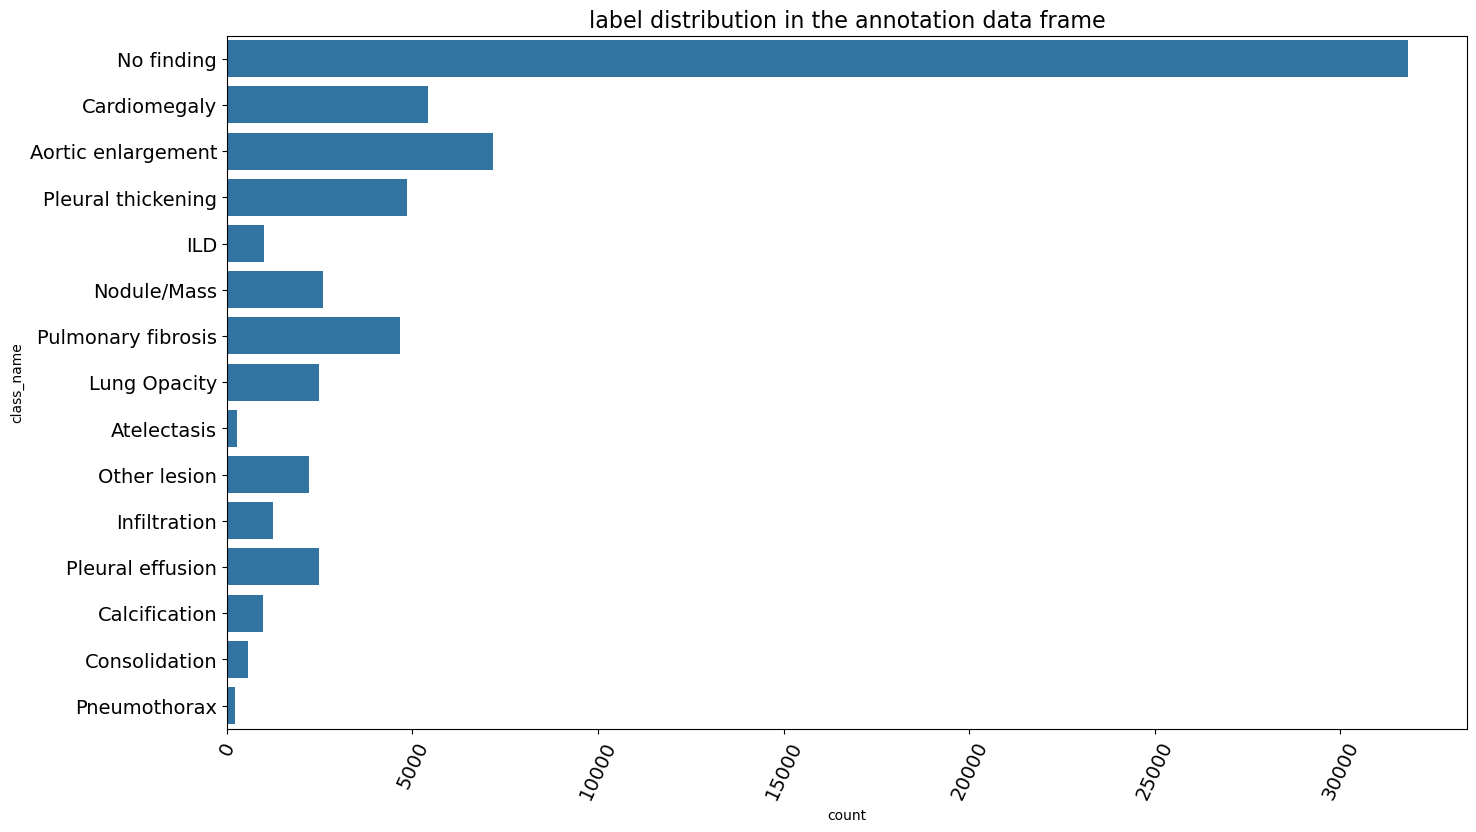

In [3]:
plt.figure(figsize=(16, 9))

sns.countplot(dataset.class_name)
plt.xticks(fontsize=14,rotation=65)
plt.yticks(fontsize=14)
plt.title("label distribution in the annotation data frame", fontsize=16)

Text(0.5, 1.0, 'Distribution of labels in the annotation data frame')

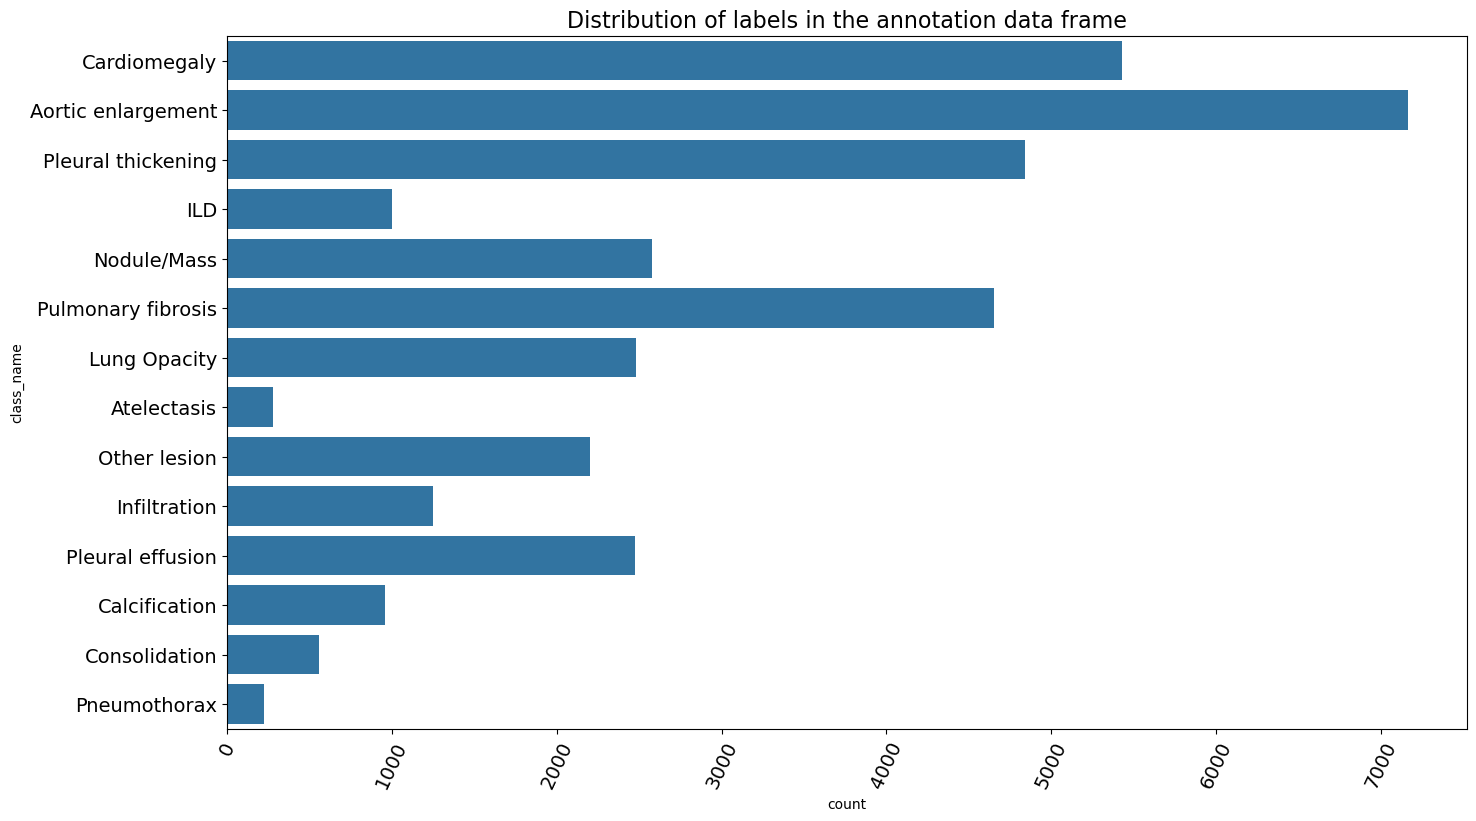

In [4]:
dataset_new = dataset[dataset.class_name!='No finding'].reset_index(drop=True) 

plt.figure(figsize=(16, 9))

sns.countplot(dataset_new.class_name)
plt.xticks(fontsize=14,rotation=65)
plt.yticks(fontsize=14)
plt.title("Distribution of labels in the annotation data frame", fontsize=16)

In [5]:
train_df, valid_df = train_test_split(dataset_new, test_size=0.33, random_state=42)

In [6]:
class LungsAnnotationDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        # Read the PNG image
        image = io.imread(f'{self.image_dir}/{image_id}.png')
        
        # Normalize the image
        image = image / 255.0  # Assuming the pixel values are in the range [0, 255]
        image = exposure.equalize_hist(image)  # Optional histogram equalization
        image = image.astype('float32')

        # If the image has 3 channels already (like RGB), no need to stack, else ensure 3 channels
        if image.ndim == 2:  # If the image is grayscale, convert to 3 channels
            image = np.stack([image, image, image], axis=-1)

        # Ensure the image is in the correct (C, H, W) format
        if image.shape[2] == 3:  # Check if image is in (H, W, C)
            image = image.transpose(2, 0, 1)  # Convert from (H, W, C) to (C, H, W)

        # Get bounding boxes and other details
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values

        # Do NOT denormalize here; keep the boxes normalized
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        labels = records.class_id.values + 1
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'area': area,
            'iscrowd': iscrowd
        }

        # Apply transformations if available (pass normalized boxes)
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32)
        
        # Denormalize boxes AFTER transformations (if you need pixel coordinates)
        target['boxes'][:, [0, 2]] = target['boxes'][:, [0, 2]] * 512  # Denormalize x_min and x_max
        target['boxes'][:, [1, 3]] = target['boxes'][:, [1, 3]] * 512  # Denormalize y_min and y_max

        return image, target


    def __len__(self):
        return len(self.image_ids)

In [7]:
def get_train_transform():
    return A.Compose([ToTensorV2(),], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([ToTensorV2(),], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [8]:
DIR_TRAIN = os.path.join( "resized_images")

train_dataset = LungsAnnotationDataset(train_df, DIR_TRAIN,get_train_transform())
valid_dataset = LungsAnnotationDataset(valid_df, DIR_TRAIN,get_valid_transform())

In [9]:
def collate_fn(batch):
    images, targets = zip(*batch)
    images = [image.permute(1, 2, 0) if image.shape[0] != 3 else image for image in images] 
    return torch.stack(images), targets


In [10]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=6,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [11]:
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=6,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [12]:
def set_device():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    return device

In [13]:
device=set_device()
print(device)

mps


In [14]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)

targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [15]:
print(len(targets))

6


In [16]:
class_brands = {
    0: 'Aortic enlargement',
    1: 'Atelectasis',
    2: 'Calcification',
    3: 'Cardiomegaly',
    4: 'Consolidation',
    5: 'ILD',
    6: 'Infiltration',
    7: 'Lung Opacity',
    8: 'Nodule/Mass',
    9: 'Other lesion',
    10: 'Pleural effusion',
    11: 'Pleural thickening',
    12: 'Pneumothorax',
    13: 'Pulmonary fibrosis'
}

In [17]:
def check_image_channels(images):
    """
    This function takes a batch of images and prints the full shape of each image to debug channels, height, and width.
    
    Args:
        images (list of torch.Tensor): A batch of images in (C, H, W) format.
    """
    for i, image in enumerate(images):
        # Ensure the image is in (C, H, W) format
        if image.shape[0] == 512:  # If the first dimension is 512, the image is in (H, C, W) format
            print(f"Image {i} is incorrectly formatted: {image.shape}, permuting back to (C, H, W).")
            image = image.permute(1, 0, 2)  # Permute back to (C, H, W)

        # Now print the correct shape
        print(f"Image {i} has shape: {image.shape}")

check_image_channels(images)

Image 0 has shape: torch.Size([3, 512, 512])
Image 1 has shape: torch.Size([3, 512, 512])
Image 2 has shape: torch.Size([3, 512, 512])
Image 3 has shape: torch.Size([3, 512, 512])
Image 4 has shape: torch.Size([3, 512, 512])
Image 5 has shape: torch.Size([3, 512, 512])


In [18]:
def plot_x_ray(idx, images, targets):
    boxes = targets[idx]['boxes'].cpu().numpy().astype(np.int32)
    labels = targets[idx]['labels'] - 1
    
    # Get the specific image and convert it back to (H, W, C) format for visualization
    image = images[idx].permute(1, 2, 0).cpu().numpy()
    
    # Debug: Print the shape after permutation
    print(f"Image {idx} shape after permutation (H, W, C): {image.shape}")

    # Ensure image is in uint8 format
    img = (image * 255).astype(np.uint8)

    # Ensure the image is contiguous in memory (required by OpenCV)
    img = np.ascontiguousarray(img)

    # Debug: Print final shape before drawing
    print(f"Final image shape before drawing: {img.shape}")

    plt.figure(figsize=(16, 16))

    for box, label in zip(boxes, labels):
        # Ensure label color matches the number of channels (should be 3 channels for RGB)
        text_bg_color = (255, 0, 0) if img.shape[-1] == 3 else (255,)  # Red for RGB, gray for grayscale
        text_color = (0, 0, 0) if img.shape[-1] == 3 else (0,)  # Black for RGB, black for grayscale

        # Add label using bbox_visualizer (adjusting color format)
        bbv.add_label(img, class_brands[label.item()], box,
                      draw_bg=True,
                      text_bg_color=text_bg_color,
                      text_color=text_color
                      )

        # Draw rectangle using OpenCV (adjusting color format)
        cv2.rectangle(img,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (255, 0, 0), 3)  # Red for rectangle in both grayscale and RGB

    plt.imshow(img)


Image 0 shape after permutation (H, W, C): (512, 512, 3)
Final image shape before drawing: (512, 512, 3)
Image 1 shape after permutation (H, W, C): (512, 512, 3)
Final image shape before drawing: (512, 512, 3)
Image 2 shape after permutation (H, W, C): (512, 512, 3)
Final image shape before drawing: (512, 512, 3)
Image 3 shape after permutation (H, W, C): (512, 512, 3)
Final image shape before drawing: (512, 512, 3)
Image 4 shape after permutation (H, W, C): (512, 512, 3)
Final image shape before drawing: (512, 512, 3)
Image 5 shape after permutation (H, W, C): (512, 512, 3)
Final image shape before drawing: (512, 512, 3)


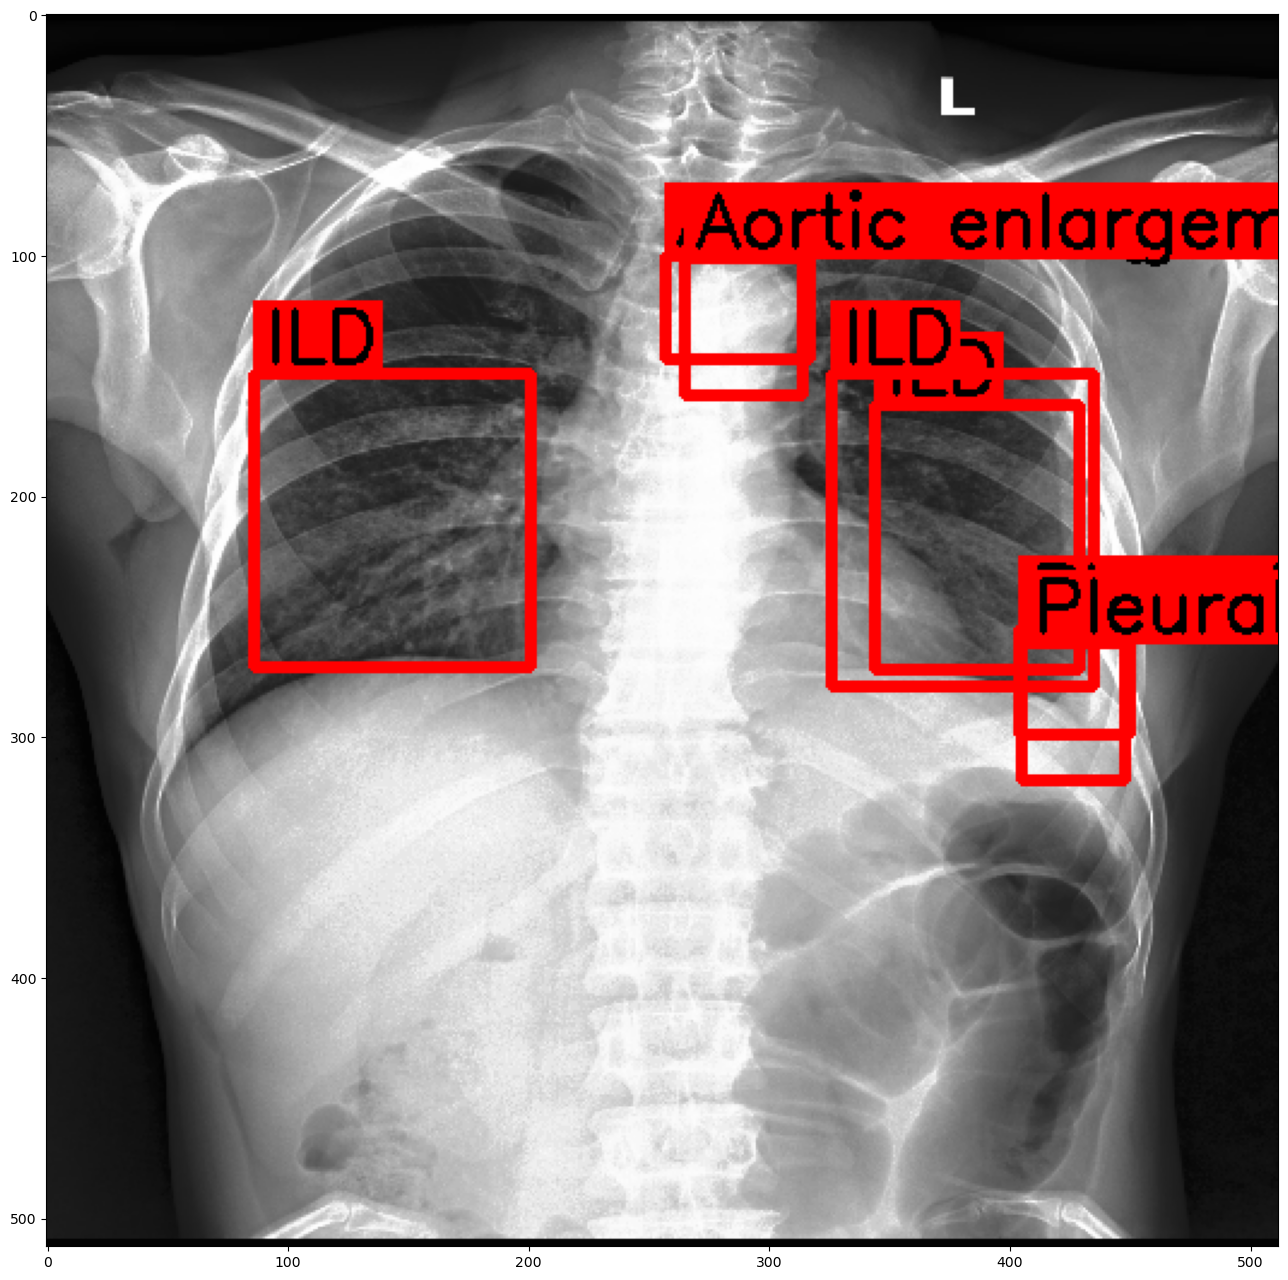

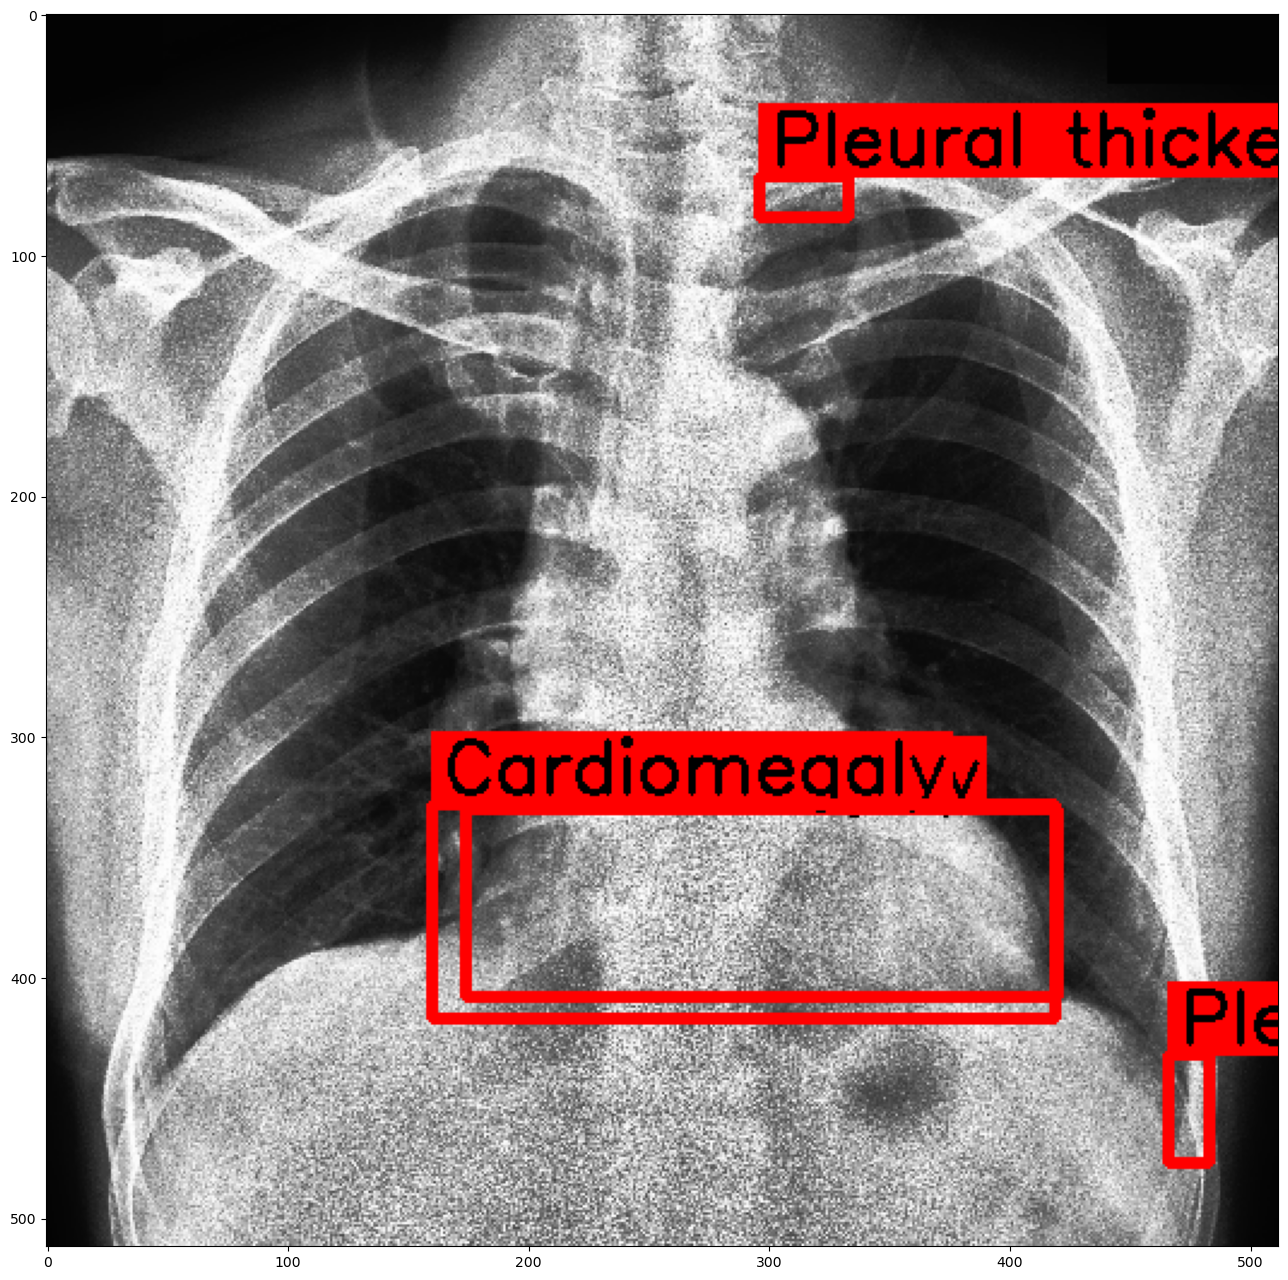

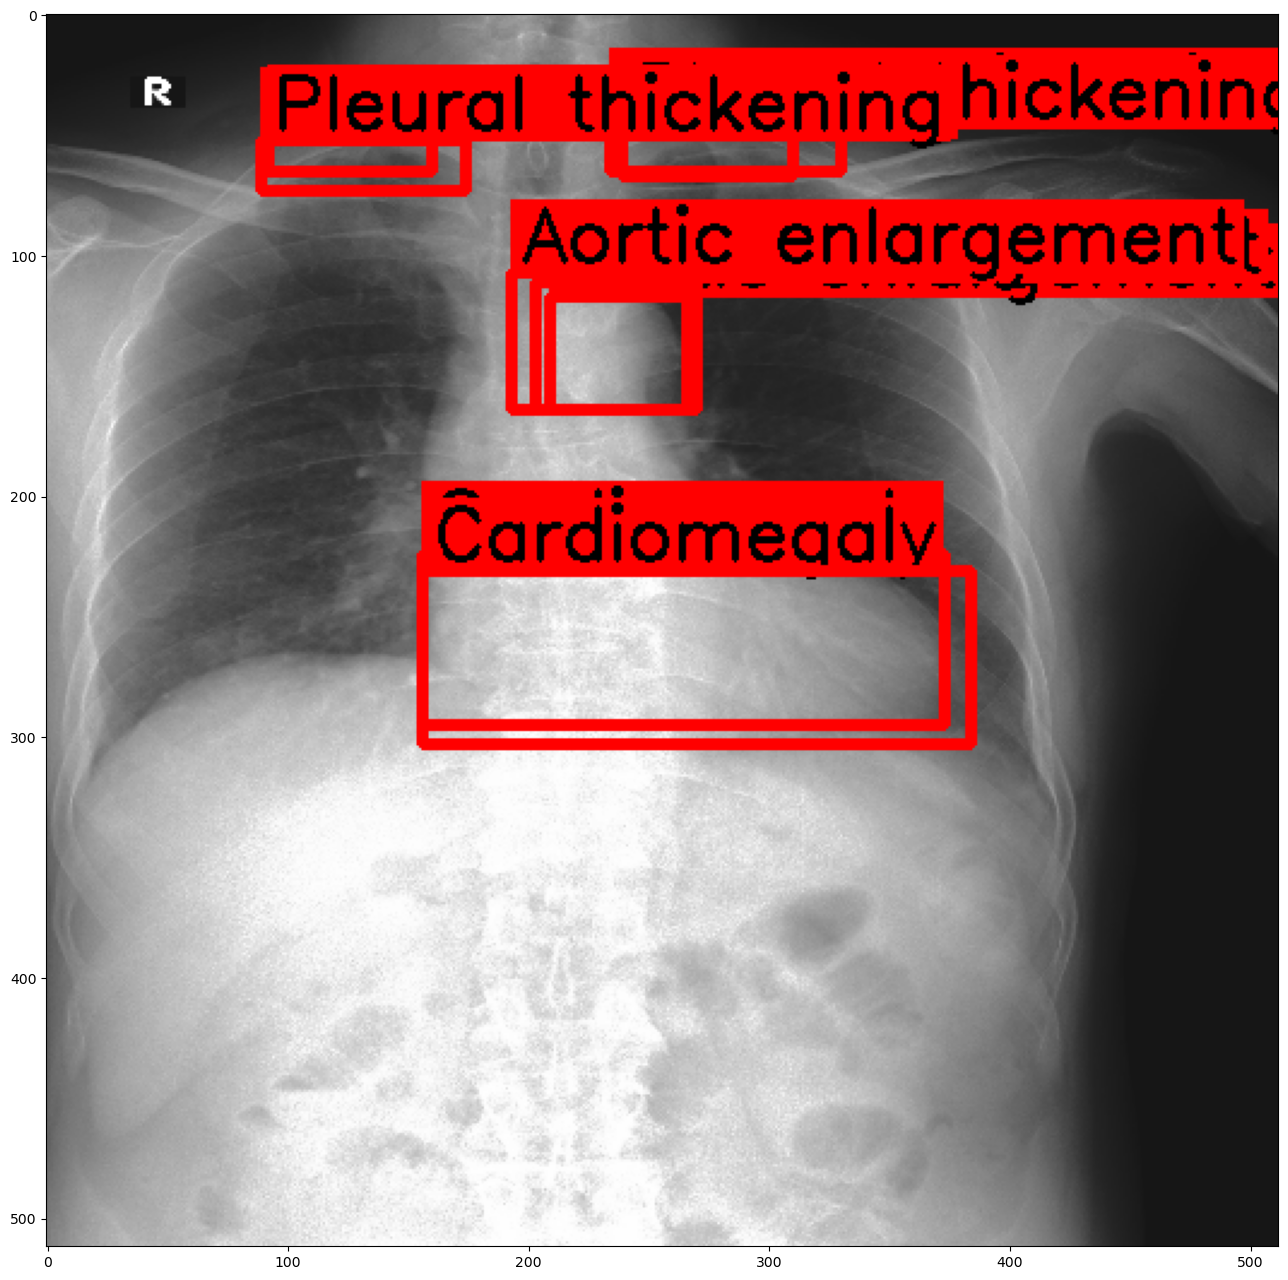

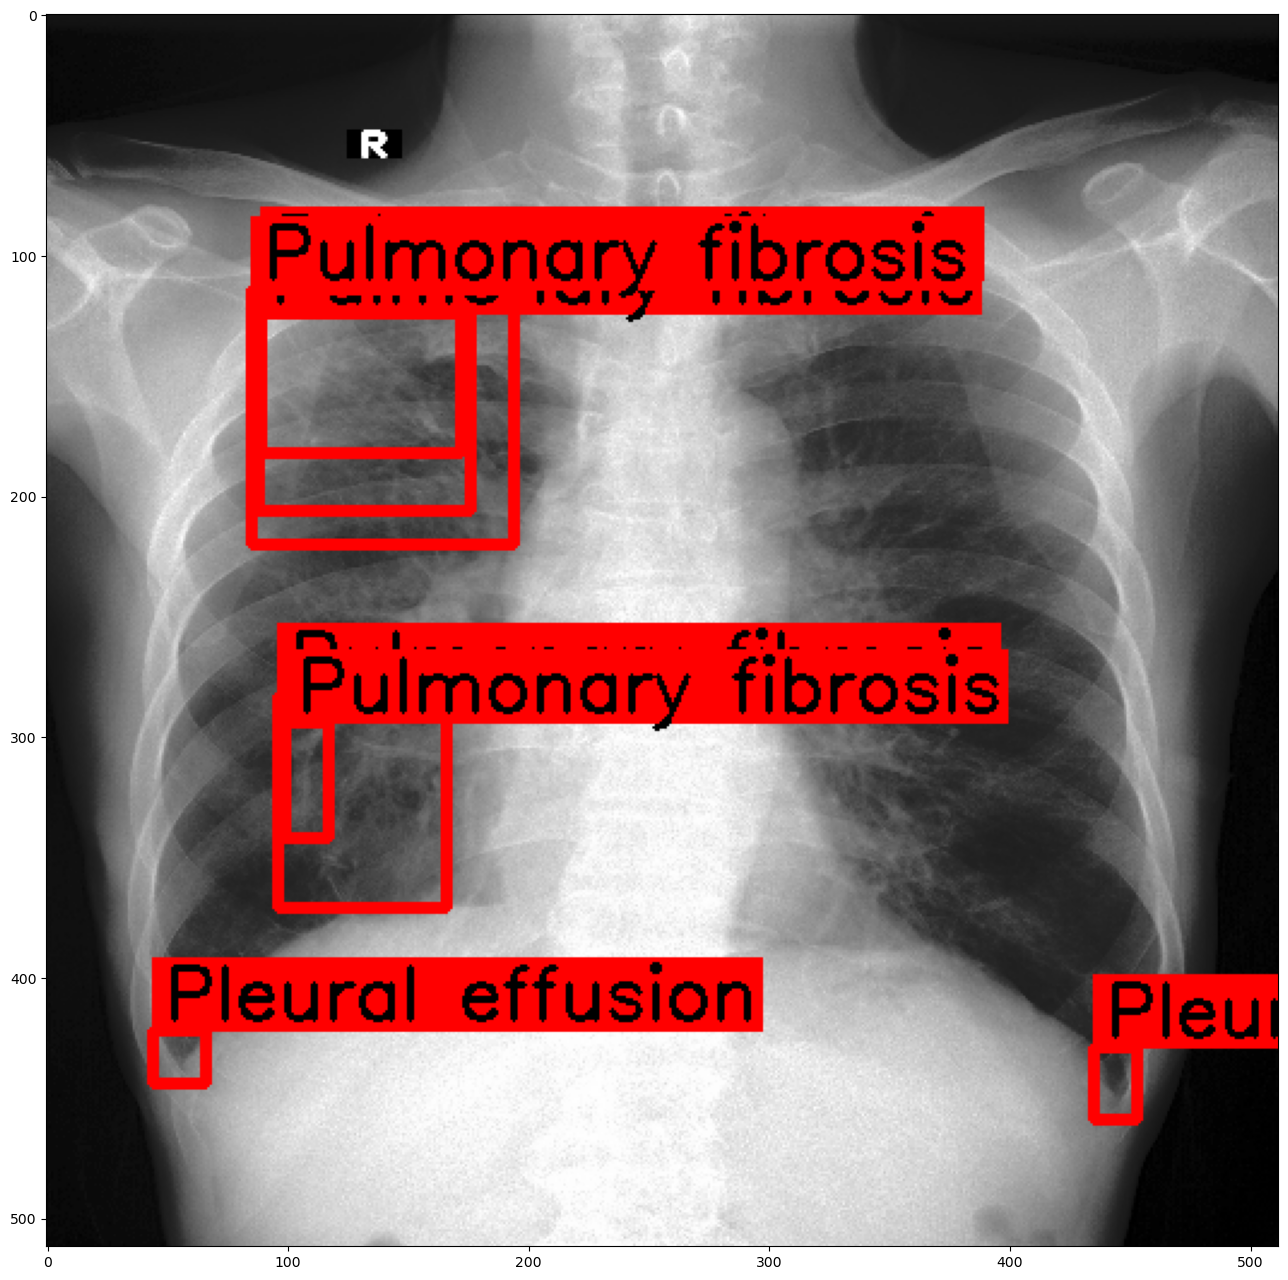

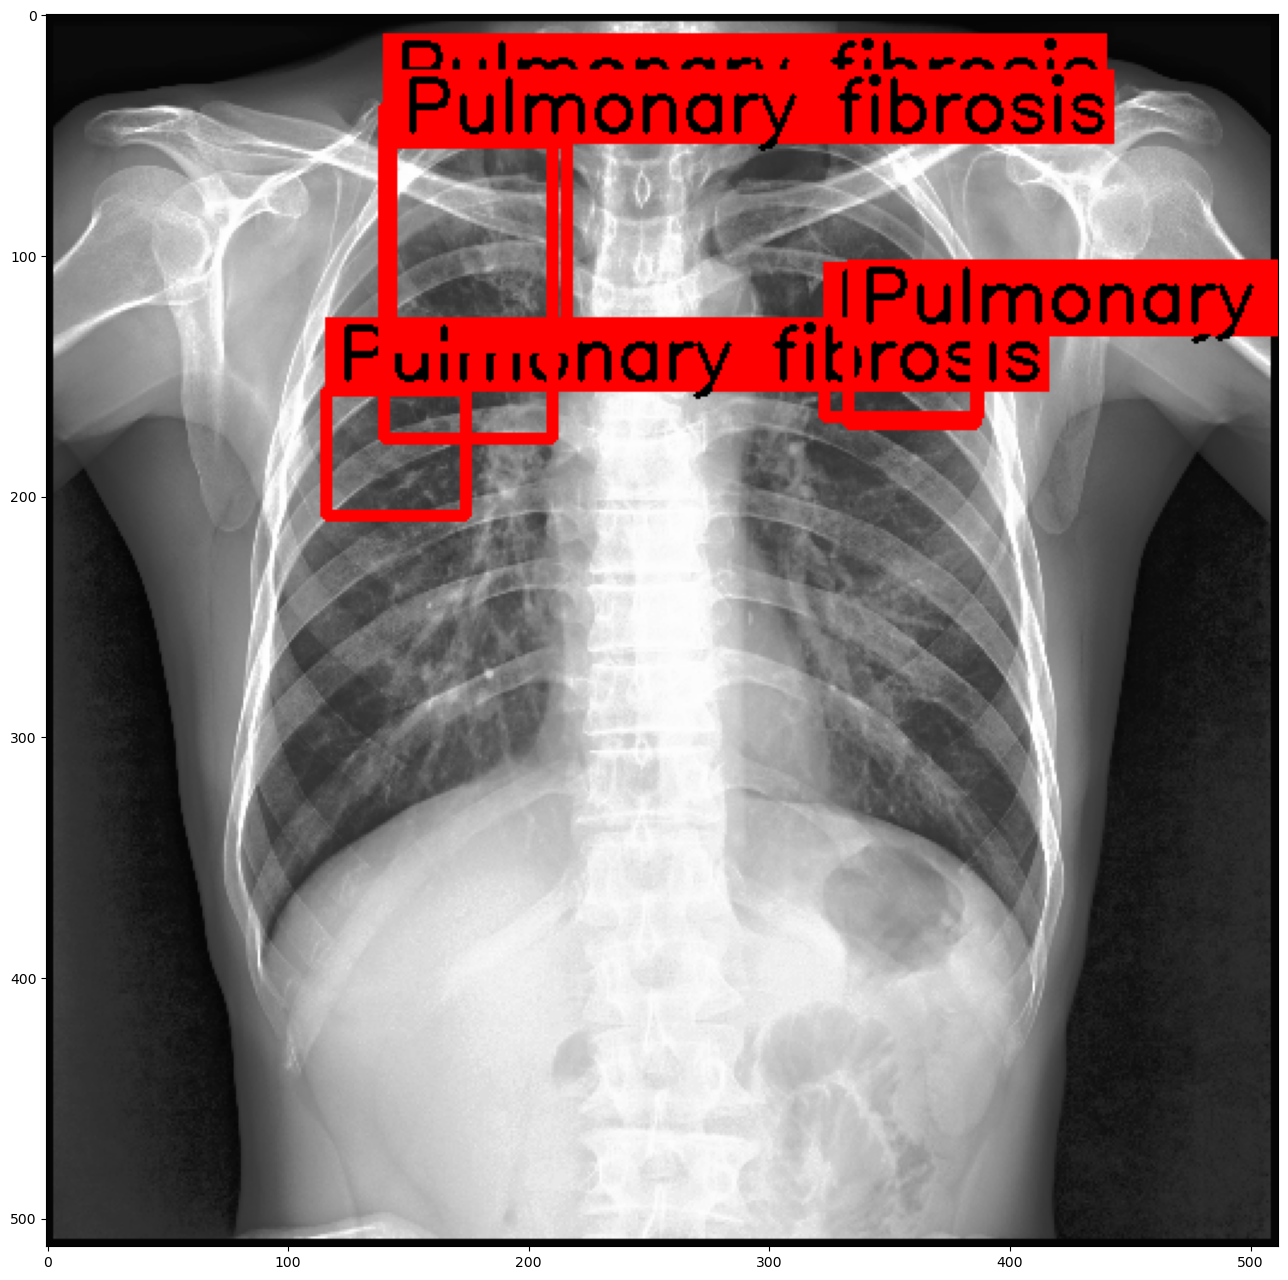

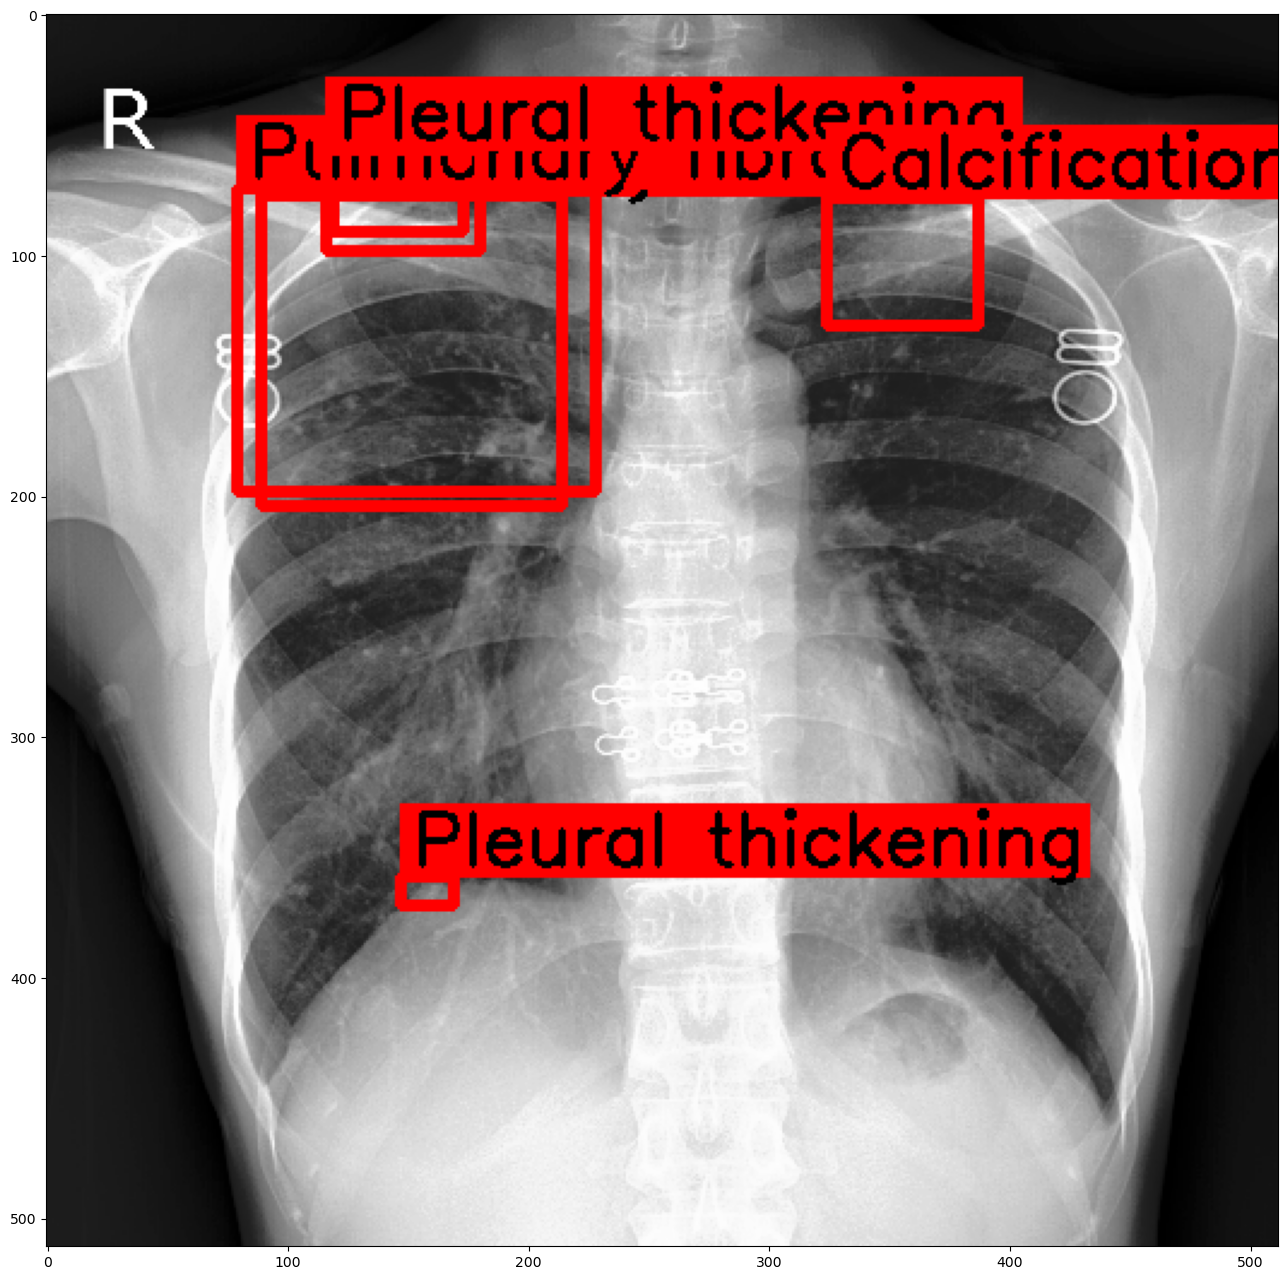

In [19]:
for i in range(len(images)):
   plot_x_ray(i, images, targets)
